# Classifying Waterpump Conditions

##### Buisness Problem: 

The Tanzanian Ministry of Water is faced with the problem that many of the water pumps in the country require maintinance. The people of Tanzania rely on these water pumps to provide clean drinking water to their communities. The Tanzanian Ministry of Water if faced with time and resource contrainsts that they want to optimize useing a Machine Learning Model.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, 
recall_score, precision_score, f1_score, classification_report, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [8]:
# Loading the Modeling Data
y = pd.read_csv('Data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv', index_col='id')
X = pd.read_csv('Data/4910797b-ee55-40a7-8668-10efd5c1b960.csv', index_col='id')

# Loading the Submission Data for 'Driven Data'
X_final = pd.read_csv('Data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')
y_final = pd.read_csv('Data/SubmissionFormat.csv')

#### Exploratory Data Analysis

In [4]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [7]:
y.value_counts(normalize=True)

status_group           
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
dtype: float64

In [16]:
# Applying labels to group 'non functional' and 'functional needs repair	' as the target variable
y['codes'] = y['status_group'].apply(lambda x: 0 if x == 'functional' else 1)

# Checking to ensure labeling worked properly
y.groupby('status_group').mean()

,codes
status_group,
functional,0
functional needs repair,1
non functional,1


* Analyzed columns using value count to get a sense for the distribution and cleanliness of the data.

In [17]:
X.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [18]:
# Example of Data used
X.value_counts('quality_group')

quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
dtype: int64

In [20]:
# Example of Data not used
# A lot of individual values (value_counts = 1) which complicates the dataset using One Hot Encoding, and doesn't give good information to seperation of the data.
X.value_counts('ward')

ward
Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Korongoni      1
Mlimani        1
Ikweha         1
Uchindile      1
Ifinga         1
Length: 2092, dtype: int64

In [23]:
# Identified 
col_used = ['basin',
           'source_type',
           'waterpoint_type_group',
           'quantity_group',
           'region',
           'quality_group',
           'payment_type',
           'extraction_type_class',
           'permit', 
           'management', 
           'lga'] 

In [25]:
target

id
69572        functional
8776         functional
34310        functional
67743    non functional
19728        functional
              ...      
60739        functional
27263        functional
37057        functional
31282        functional
26348        functional
Name: status_group, Length: 59400, dtype: object

* Splitting the data

In [26]:
data = pd.get_dummies(X[col_used]) # One Hot Encoding for data features (Used for Categorical Variables, ie. all of the data) 
target = y.codes

X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=target)

##### Naive Bayes

recall score = 0.6154753131908622
precision score = 0.6942643391521197


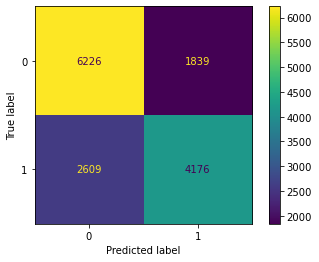

In [30]:
gnb_pipe = Pipeline([('gnb', GaussianNB())])
gnb_grid = [{'gnb__var_smoothing':[1e-9]}] # Default Parameters
gnb_search = GridSearchCV(gnb_pipe, gnb_grid, scoring='recall')

gnb_search.fit(X_train, y_train.codes)
gnb_preds = gnb_search.predict(X_test)
gnb_recall = recall_score(y_test.codes, gnb_preds)
gnb_prec = precision_score(y_test.codes, gnb_preds)

print(f'recall score = {gnb_recall}')
print(f'precision score = {gnb_prec}')
plot_confusion_matrix(gnb_search, X_test, y_test.codes)

##### K-Nearest Neighbors

score = 0.7638383838383839
recall = 0.7092114959469418
precision = 0.7582729278285534


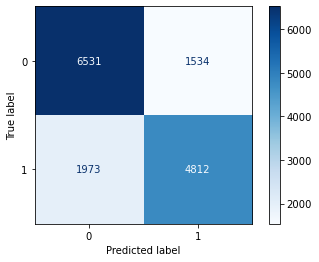

In [31]:
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])

knn_pipe.fit(X_train, y_train.codes)

y_preds = knn_pipe.predict(X_test)
knn_baseline_report = classification_report(y_test.codes, y_preds, digits=4)
knn_baseline_matrix = confusion_matrix(y_test.codes, y_preds, normalize='true')
knn_preds = knn_pipe.predict(X_test)
knn_recall = recall_score(y_test.codes, knn_preds)

print(f'score = {knn_pipe.score(X_test, y_test.codes)}')
print(f'recall = {knn_recall}')
print(f'precision = {precision_score(y_test.codes, knn_preds)}')
plot_confusion_matrix(knn_pipe, X_test, y_test.codes, cmap='Blues')

##### Random Forest *Model Selected

score = 0.7898989898989899
recall = 0.7280766396462786


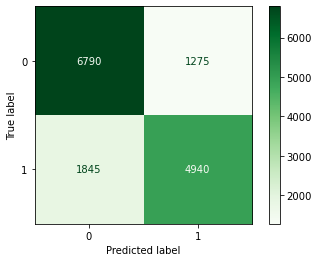

In [33]:
rfc_pipe = Pipeline([('rfc', RandomForestClassifier(oob_score=True))])

rfc_pipe.fit(X_train, y_train.codes)

rfc_preds = rfc_pipe.predict(X_test)
rfc_recall = recall_score(y_test.codes, rfc_preds)

print(f'score = {rfc_pipe.score(X_test, y_test.codes)}')
print(f'recall = {rfc_recall}')

plot_confusion_matrix(rfc_pipe, X_test, y_test.codes, cmap='Greens')

Used 'GridSearchCV' to tune the hyper parameters (Increases recall by ~.05 compared to baseline) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.0min finished


0.7322033898305085
random forest tuned recall = 0.7322033898305085
{'rfc__criterion': 'entropy', 'rfc__max_depth': 200, 'rfc__max_features': 'auto', 'rfc__min_samples_split': 2}


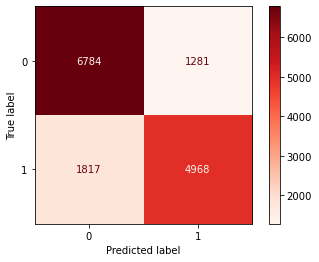

In [34]:
rfc_grid = [{'rfc__max_depth': [150, 200, 250], 
         'rfc__min_samples_split': [2], 
         'rfc__criterion': ['gini', 'entropy'],
         'rfc__max_features': ['auto']}] 

rfc_gridsearch = GridSearchCV(rfc_pipe, rfc_grid, scoring='recall', cv=5, verbose=2, n_jobs=4) 

rfc_gridsearch.fit(X_train, y_train.codes)

rfc_tuned_preds = rfc_gridsearch.predict(X_test)
rfc_tuned_recall = recall_score(y_test.codes, rfc_tuned_preds)

print(rfc_gridsearch.score(X_test, y_test.codes))
print(f'random forest tuned recall = {rfc_tuned_recall}')
print(rfc_gridsearch.best_params_)
plot_confusion_matrix(rfc_gridsearch, X_test, y_test.codes, cmap='Reds')

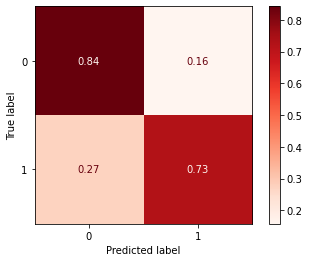

In [108]:
plot_confusion_matrix(rfc_gridsearch, X_test, y_test.codes, cmap='Reds', normalize='true')

##### XGBoost Classifier

training score = 0.7997530864197531
testing score = 0.788080808080808
0.6913780397936625


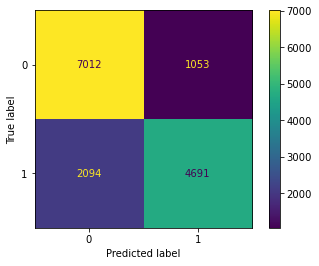

In [35]:
# Baseline scores using XGBoost

xg_pipe = Pipeline([('xg', XGBClassifier())])

xg_pipe.fit(X_train, y_train.codes)

print(f'training score = {xg_pipe.score(X_train, y_train.codes)}')
print(f'testing score = {xg_pipe.score(X_test, y_test.codes)}')

xg_preds = xg_pipe.predict(X_test)
xg_baseline_recall = recall_score(y_test.codes, xg_preds)
print(xg_baseline_recall)

plot_confusion_matrix(xg_pipe, X_test, y_test.codes)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4, total=   4.2s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4, total=   4.1s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4 ...
[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4, total=   4.0s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4 ...
[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4, total=   4.1s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4 ...
[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=4, total=   4.1s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=8 ...
[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=8, total=   7.5s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=8 ...
[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=8, total=   7.5s
[CV] xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=8 ...
[CV]  xg__booster=gbtree, xg__eta=0.2, xg__gamma=0, xg__max_depth=8, total= 

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.8min finished


training score = 0.7315779131460012
testing score = 0.7127487103905674
recall = 0.7127487103905674


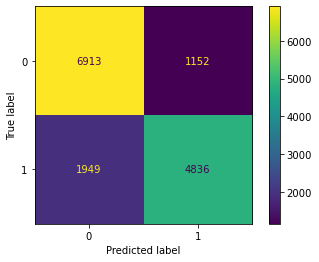

In [36]:
xg_grid = [{'xg__booster' : ['gbtree'], # gbtree is default
           'xg__eta' : [.2, .4], # .3 is default # LEARNING RATE
           'xg__gamma' : [0, 1], # 0 is default
           'xg__max_depth' : [4, 8]}] # 6 is default

xg_gridsearch = GridSearchCV(xg_pipe, xg_grid, scoring='recall', cv=5) # verbose=2, n_jobs = 2
xg_gridsearch.fit(X_train, y_train.codes)

print(f'training score = {xg_gridsearch.score(X_train, y_train.codes)}')
print(f'testing score = {xg_gridsearch.score(X_test, y_test.codes)}')

xg_tuned_preds = xg_gridsearch.predict(X_test)
xg_tuned_recall = recall_score(y_test.codes, xg_tuned_preds)

print(f'recall = {xg_tuned_recall}')
print(f'precision = {precision_score(y_test.codes, xg_tuned_preds)}')

plot_confusion_matrix(xg_gridsearch, X_test, y_test.codes)

##### Support Vector Machine

In [37]:
svm_pipe = Pipeline([('svm', SVC())])

svm_pipe.fit(X_train, y_train.codes)
svm_bl_preds = svm_pipe.predict(X_test)

print(f'training scores = {svm_pipe.score(X_train, y_train.codes)}')
print(f'testing scores = {svm_pipe.score(X_test, y_test.codes)}')
print(f'recall = {recall_score(y_test.codes, svm_bl_preds)}')
print(f'precision = {precision_score(y_test.codes, svm_bl_preds)}')

plot_confusion_matrix(svm_pipe, X_test, y_test.codes)

training scores = 0.8041301907968574
testing scores = 0.7903030303030303
recall = 0.6972733971997053


In [ ]:
svm_grid = [{'svm__kernel': ['poly', 'rbf'],
             'svm__degree': [2, 3, 4],
             'svm__decision_function_shape': ['ovo', 'ovr'],
             'svm__gamma' : [.1, .2],
             'svm__C' : [.1, 1, 10]}]

svm_gridsearch = GridSearchCV(svm_pipe, svm_grid, scoring='recall', cv=5) #verbose=2, n_jobs=4
svm_gridsearch.fit(X_train, y_train.codes)

svm_gs_preds = svm_gridsearch.predict(X_test)

print(svm_gridsearch.best_params_)
print(f'training score = {svm_gridsearch.score(X_train, y_train.codes)}')
print(f'testing score = {svm_gridsearch.score(X_test, y_test.codes)}')
print(f'recall = {recall_score(y_test.codes, svm_gs_preds)}')
print(f'precision = {precision_score(y_test.codes, svm_gs_preds)}')

plot_confusion_matrix(svm_gridsearch, X_test, y_test.codes)